In [7]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

## Data Preparation

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified


## Model Architecture

In [30]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if(self.use_bn):
                x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

## Train, Validate, Test and Experiment

In [11]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [12]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [13]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [23]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

## Manage Experiment Result

In [15]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

## Visualization Utility

In [16]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

## Experiment1. n_layer & dropout

In [17]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_dropout"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 500
args.n_layer = 2
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 30

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'dropout'
list_var1 = [1, 2, 3]
list_var2 = [0.1, 0.2, 0.3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.1, epoch=30, exp_name='exp1_n_layer_dropout', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 23.74/23.48, Loss(train/val) 24.92/28.37. Took 4.16 sec
Epoch 1, Acc(train/val): 26.44/21.57, Loss(train/val) 20.21/21.12. Took 4.32 sec
Epoch 2, Acc(train/val): 26.57/24.21, Loss(train/val) 18.38/25.91. Took 4.31 sec
Epoch 3, Acc(train/val): 26.89/23.28, Loss(train/val) 17.54/20.59. Took 4.27 sec
Epoch 4, Acc(train/val): 26.75/25.89, Loss(train/val) 17.80/20.73. Took 4.29 sec
Epoch 5, Acc(train/val): 27.65/26.97, Loss(train/val) 16.62/22.92. Took 4.12 sec
Epoch 6, Acc(train/val): 27.36/23.90, Loss(train/val) 18.05/22.07. Took 4.14 sec
Epoch 7, Acc(train/val): 28.37/23.90, Loss(train/val) 16.90/23.19. Took 4.27 sec
Epoch 8, Acc(train/val): 27.98/26.20, Loss(train/val) 18.95/27.29. Took 4.21 sec
Epoch 9, Acc(train/val): 29.19/2

Epoch 0, Acc(train/val): 29.13/32.69, Loss(train/val) 2.00/1.87. Took 4.41 sec
Epoch 1, Acc(train/val): 33.70/35.68, Loss(train/val) 1.84/1.86. Took 4.23 sec
Epoch 2, Acc(train/val): 37.40/38.38, Loss(train/val) 1.74/1.89. Took 4.12 sec
Epoch 3, Acc(train/val): 40.44/40.82, Loss(train/val) 1.67/1.67. Took 4.13 sec
Epoch 4, Acc(train/val): 42.03/42.56, Loss(train/val) 1.61/1.61. Took 4.13 sec
Epoch 5, Acc(train/val): 44.72/44.32, Loss(train/val) 1.55/1.85. Took 4.08 sec
Epoch 6, Acc(train/val): 47.84/46.04, Loss(train/val) 1.47/1.53. Took 4.09 sec
Epoch 7, Acc(train/val): 49.48/46.32, Loss(train/val) 1.42/1.88. Took 4.12 sec
Epoch 8, Acc(train/val): 51.35/47.69, Loss(train/val) 1.37/1.61. Took 4.01 sec
Epoch 9, Acc(train/val): 53.09/46.55, Loss(train/val) 1.32/1.79. Took 3.97 sec
Epoch 10, Acc(train/val): 54.66/48.14, Loss(train/val) 1.28/1.48. Took 3.99 sec
Epoch 11, Acc(train/val): 55.86/48.14, Loss(train/val) 1.25/1.49. Took 3.99 sec
Epoch 12, Acc(train/val): 57.12/49.92, Loss(train/

Epoch 4, Acc(train/val): 41.58/41.44, Loss(train/val) 1.62/1.92. Took 4.00 sec
Epoch 5, Acc(train/val): 43.95/41.84, Loss(train/val) 1.56/1.74. Took 4.02 sec
Epoch 6, Acc(train/val): 45.92/43.28, Loss(train/val) 1.51/5.08. Took 4.02 sec
Epoch 7, Acc(train/val): 47.40/45.68, Loss(train/val) 1.47/1.58. Took 4.01 sec
Epoch 8, Acc(train/val): 50.73/47.54, Loss(train/val) 1.38/2.37. Took 4.16 sec
Epoch 9, Acc(train/val): 52.73/47.44, Loss(train/val) 1.32/1.58. Took 3.97 sec
Epoch 10, Acc(train/val): 54.28/47.15, Loss(train/val) 1.28/1.56. Took 4.12 sec
Epoch 11, Acc(train/val): 55.66/50.09, Loss(train/val) 1.24/1.54. Took 3.96 sec
Epoch 12, Acc(train/val): 57.24/49.18, Loss(train/val) 1.19/1.47. Took 4.04 sec
Epoch 13, Acc(train/val): 58.68/50.49, Loss(train/val) 1.16/1.44. Took 4.00 sec
Epoch 14, Acc(train/val): 60.66/49.92, Loss(train/val) 1.11/1.51. Took 4.00 sec
Epoch 15, Acc(train/val): 59.95/48.46, Loss(train/val) 1.13/5.46. Took 4.02 sec
Epoch 16, Acc(train/val): 60.54/49.62, Loss(tr

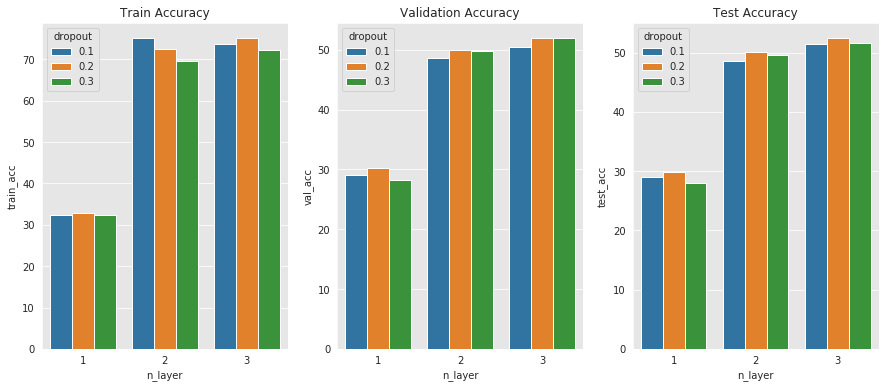

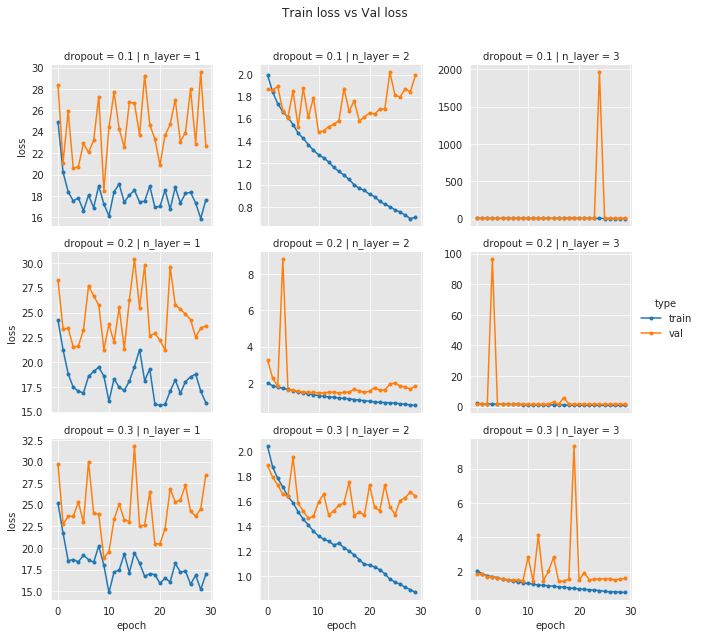

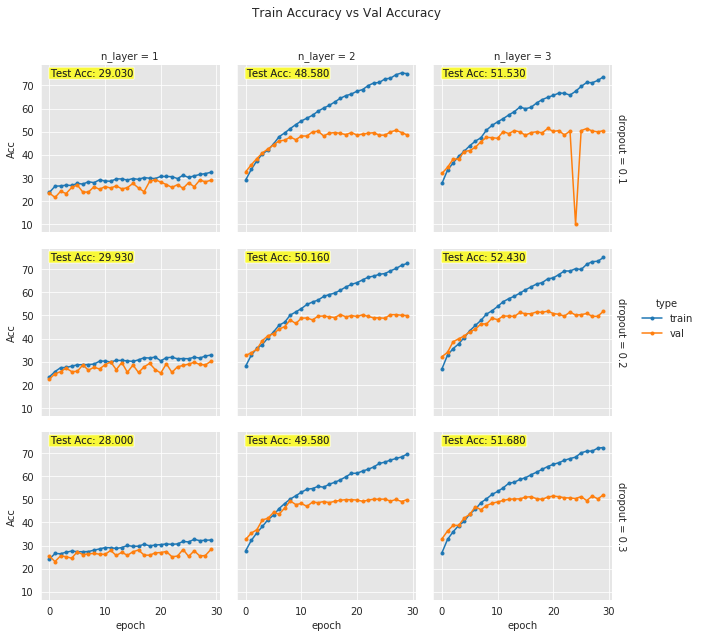

In [21]:
var1 = 'n_layer'
var2 = 'dropout'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

## Experiment2. optimizer vs dropout

In [24]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_n_layer_optim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 500
args.n_layer = 2
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 50

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'optim'
list_var1 = [2, 3]
list_var2 = ['RMSprop', 'SGD', 'Adam']


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=50, exp_name='exp2_n_layer_optim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=2, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 27.76/33.57, Loss(train/val) 2.04/1.86. Took 4.32 sec
Epoch 1, Acc(train/val): 33.08/36.89, Loss(train/val) 1.86/1.76. Took 4.26 sec
Epoch 2, Acc(train/val): 36.31/37.10, Loss(train/val) 1.76/1.83. Took 4.31 sec
Epoch 3, Acc(train/val): 38.55/39.43, Loss(train/val) 1.70/1.78. Took 4.16 sec
Epoch 4, Acc(train/val): 40.72/40.47, Loss(train/val) 1.65/2.68. Took 4.24 sec
Epoch 5, Acc(train/val): 42.53/42.96, Loss(train/val) 1.60/3.42. Took 4.27 sec
Epoch 6, Acc(train/val): 46.18/46.46, Loss(train/val) 1.52/2.08. Took 4.12 sec
Epoch 7, Acc(train/val): 48.04/44.44, Loss(train/val) 1.46/2.03. Took 4.18 sec
Epoch 8, Acc(train/val): 49.83/47.52, Loss(train/val) 1.41/1.52. Took 4.13 sec
Epoch 9, Acc(train/val): 52.12/47.31, Loss(train/val

Epoch 47, Acc(train/val): 84.16/50.57, Loss(train/val) 0.45/1.99. Took 4.07 sec
Epoch 48, Acc(train/val): 84.07/51.01, Loss(train/val) 0.45/2.07. Took 4.14 sec
Epoch 49, Acc(train/val): 84.65/51.03, Loss(train/val) 0.44/2.03. Took 4.06 sec
Namespace(act='relu', dropout=0.2, epoch=50, exp_name='exp2_n_layer_optim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=2, optim='Adam', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 21.72/19.61, Loss(train/val) 3.01/3.89. Took 4.11 sec
Epoch 1, Acc(train/val): 20.36/22.97, Loss(train/val) 3.17/4.09. Took 4.14 sec
Epoch 2, Acc(train/val): 21.24/20.13, Loss(train/val) 3.36/3.61. Took 4.10 sec
Epoch 3, Acc(train/val): 21.49/25.48, Loss(train/val) 3.68/5.17. Took 4.10 sec
Epoch 4, Acc(train/val): 19.18/16.11, Loss(train/val) 4.74/5.83. Took 4.09 sec
Epoch 5, Acc(train/val): 19.62/20.32, Loss(train/val) 5.05/8.87. Took 4.13 sec
Epoch 6, Acc(train/val): 18.89/19.58, Loss(train/val

Epoch 44, Acc(train/val): 82.95/50.93, Loss(train/val) 0.50/2.01. Took 4.04 sec
Epoch 45, Acc(train/val): 83.43/51.26, Loss(train/val) 0.48/2.09. Took 4.06 sec
Epoch 46, Acc(train/val): 82.51/50.17, Loss(train/val) 0.52/1.84. Took 4.14 sec
Epoch 47, Acc(train/val): 81.26/49.88, Loss(train/val) 0.54/2.00. Took 4.11 sec
Epoch 48, Acc(train/val): 83.52/50.66, Loss(train/val) 0.48/2.08. Took 4.09 sec
Epoch 49, Acc(train/val): 84.89/51.34, Loss(train/val) 0.44/2.14. Took 4.14 sec
Namespace(act='relu', dropout=0.2, epoch=50, exp_name='exp2_n_layer_optim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=3, optim='SGD', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 33.15/39.06, Loss(train/val) 1.87/1.71. Took 4.16 sec
Epoch 1, Acc(train/val): 39.48/41.33, Loss(train/val) 1.69/1.62. Took 4.06 sec
Epoch 2, Acc(train/val): 43.21/44.69, Loss(train/val) 1.59/1.55. Took 4.07 sec
Epoch 3, Acc(train/val): 45.81/45.91, Loss(train/v

Epoch 41, Acc(train/val): 26.66/23.76, Loss(train/val) 2.10/45.76. Took 4.23 sec
Epoch 42, Acc(train/val): 27.32/21.50, Loss(train/val) 2.13/2.26. Took 4.17 sec
Epoch 43, Acc(train/val): 26.53/20.87, Loss(train/val) 2.30/12.83. Took 4.17 sec
Epoch 44, Acc(train/val): 24.06/16.50, Loss(train/val) 2.78/58.17. Took 4.02 sec
Epoch 45, Acc(train/val): 18.78/15.51, Loss(train/val) 6.55/25.70. Took 4.26 sec
Epoch 46, Acc(train/val): 15.76/17.51, Loss(train/val) 9.71/105.48. Took 4.23 sec
Epoch 47, Acc(train/val): 19.01/11.84, Loss(train/val) 6.91/8.01. Took 4.13 sec
Epoch 48, Acc(train/val): 16.95/16.37, Loss(train/val) 5.74/937.75. Took 4.14 sec
Epoch 49, Acc(train/val): 16.26/14.41, Loss(train/val) 7.00/173.32. Took 4.20 sec


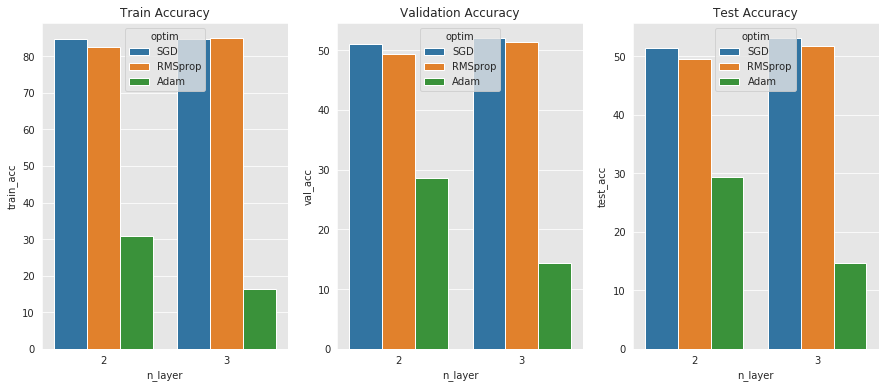

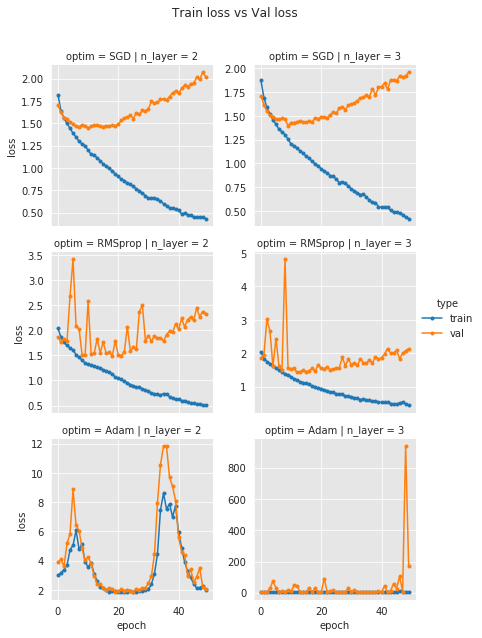

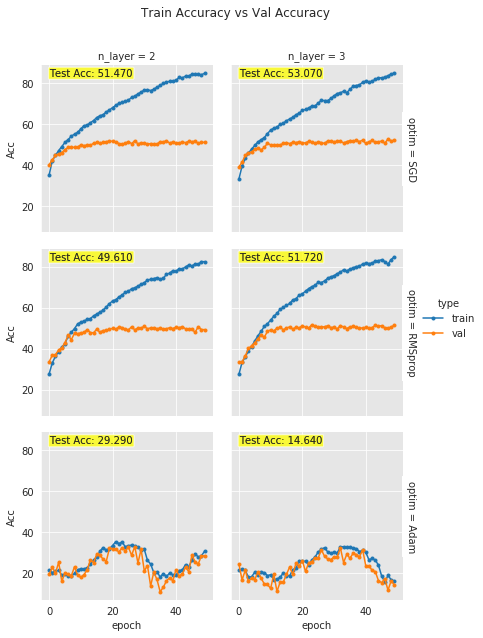

In [26]:
var1 = 'n_layer'
var2 = 'optim'
df = load_exp_result('exp2')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

## Experiment3. learning rate & batch normalization

In [32]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_lr_use_bn"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 500
args.n_layer = 2
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.1
args.use_bn = False
args.l2 = 0.01
args.use_xavier = False

# ====== Optimizer & Training ====== #
args.optim = 'SGD' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 100

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'use_bn'
list_var1 = [0.001, 0.0015]
list_var2 = [True, False]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.1, epoch=100, exp_name='exp3_lr_use_bn', hid_dim=500, in_dim=3072, l2=0.01, lr=0.001, n_layer=2, optim='SGD', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=False)
Epoch 0, Acc(train/val): 34.41/39.17, Loss(train/val) 1.84/1.71. Took 4.18 sec
Epoch 1, Acc(train/val): 41.66/43.01, Loss(train/val) 1.64/1.61. Took 4.06 sec
Epoch 2, Acc(train/val): 45.67/44.96, Loss(train/val) 1.54/1.55. Took 4.10 sec
Epoch 3, Acc(train/val): 48.54/46.29, Loss(train/val) 1.47/1.52. Took 4.15 sec
Epoch 4, Acc(train/val): 50.29/47.80, Loss(train/val) 1.42/1.48. Took 4.05 sec
Epoch 5, Acc(train/val): 51.98/48.01, Loss(train/val) 1.37/1.48. Took 4.42 sec
Epoch 6, Acc(train/val): 52.83/46.96, Loss(train/val) 1.35/1.50. Took 4.53 sec
Epoch 7, Acc(train/val): 53.56/46.82, Loss(train/val) 1.33/1.49. Took 4.74 sec
Epoch 8, Acc(train/val): 54.30/47.65, Loss(train/val) 1.31/1.48. Took 4.72 sec
Epoch 9, Acc(train/val): 54.62/46.84, Loss(train/val) 1.29/1

Namespace(act='relu', dropout=0.1, epoch=100, exp_name='exp3_lr_use_bn', hid_dim=500, in_dim=3072, l2=0.01, lr=0.001, n_layer=2, optim='SGD', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=False, use_xavier=False)
Epoch 0, Acc(train/val): 23.34/30.33, Loss(train/val) 2.13/1.95. Took 4.10 sec
Epoch 1, Acc(train/val): 33.90/37.36, Loss(train/val) 1.85/1.76. Took 4.08 sec
Epoch 2, Acc(train/val): 39.06/40.34, Loss(train/val) 1.72/1.68. Took 4.02 sec
Epoch 3, Acc(train/val): 41.87/42.58, Loss(train/val) 1.64/1.63. Took 4.13 sec
Epoch 4, Acc(train/val): 44.20/42.97, Loss(train/val) 1.59/1.59. Took 4.08 sec
Epoch 5, Acc(train/val): 45.82/43.89, Loss(train/val) 1.54/1.58. Took 4.12 sec
Epoch 6, Acc(train/val): 46.81/45.13, Loss(train/val) 1.51/1.55. Took 4.11 sec
Epoch 7, Acc(train/val): 47.69/45.57, Loss(train/val) 1.48/1.54. Took 4.07 sec
Epoch 8, Acc(train/val): 48.67/45.67, Loss(train/val) 1.46/1.52. Took 4.07 sec
Epoch 9, Acc(train/val): 49.46/46.56, Loss(train/val) 1.44/

Namespace(act='relu', dropout=0.1, epoch=100, exp_name='exp3_lr_use_bn', hid_dim=500, in_dim=3072, l2=0.01, lr=0.0015, n_layer=2, optim='SGD', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=False)
Epoch 0, Acc(train/val): 36.15/40.06, Loss(train/val) 1.80/1.68. Took 4.14 sec
Epoch 1, Acc(train/val): 42.69/43.03, Loss(train/val) 1.61/1.60. Took 4.05 sec
Epoch 2, Acc(train/val): 46.20/45.58, Loss(train/val) 1.52/1.54. Took 4.18 sec
Epoch 3, Acc(train/val): 48.83/47.01, Loss(train/val) 1.45/1.50. Took 4.44 sec
Epoch 4, Acc(train/val): 50.41/45.57, Loss(train/val) 1.41/1.53. Took 4.21 sec
Epoch 5, Acc(train/val): 51.01/46.16, Loss(train/val) 1.39/1.52. Took 4.06 sec
Epoch 6, Acc(train/val): 51.80/46.71, Loss(train/val) 1.38/1.50. Took 4.09 sec
Epoch 7, Acc(train/val): 52.58/45.65, Loss(train/val) 1.36/1.52. Took 4.09 sec
Epoch 8, Acc(train/val): 52.93/46.37, Loss(train/val) 1.34/1.51. Took 4.13 sec
Epoch 9, Acc(train/val): 53.79/46.52, Loss(train/val) 1.33/

Namespace(act='relu', dropout=0.1, epoch=100, exp_name='exp3_lr_use_bn', hid_dim=500, in_dim=3072, l2=0.01, lr=0.0015, n_layer=2, optim='SGD', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=False, use_xavier=False)
Epoch 0, Acc(train/val): 24.43/31.84, Loss(train/val) 2.11/1.92. Took 4.14 sec
Epoch 1, Acc(train/val): 35.13/37.79, Loss(train/val) 1.82/1.74. Took 4.10 sec
Epoch 2, Acc(train/val): 40.27/41.85, Loss(train/val) 1.67/1.64. Took 4.10 sec
Epoch 3, Acc(train/val): 43.00/42.98, Loss(train/val) 1.60/1.61. Took 4.29 sec
Epoch 4, Acc(train/val): 45.13/43.27, Loss(train/val) 1.55/1.58. Took 4.11 sec
Epoch 5, Acc(train/val): 46.16/44.35, Loss(train/val) 1.52/1.56. Took 4.14 sec
Epoch 6, Acc(train/val): 47.77/45.09, Loss(train/val) 1.48/1.54. Took 4.03 sec
Epoch 7, Acc(train/val): 48.92/46.37, Loss(train/val) 1.45/1.52. Took 4.13 sec
Epoch 8, Acc(train/val): 49.80/46.15, Loss(train/val) 1.43/1.51. Took 4.07 sec
Epoch 9, Acc(train/val): 50.27/46.67, Loss(train/val) 1.41

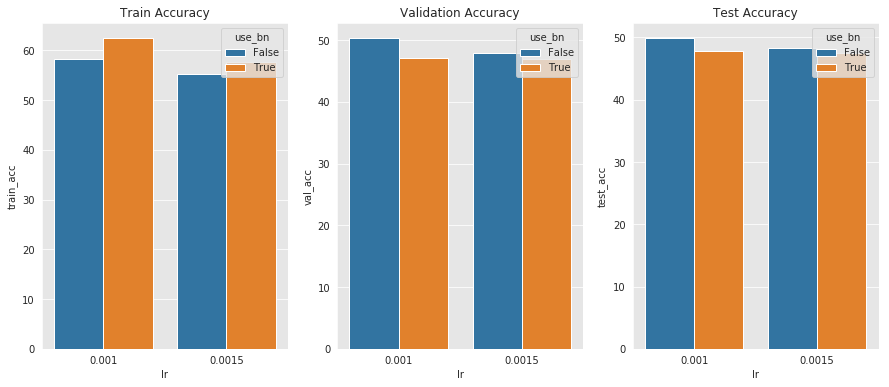

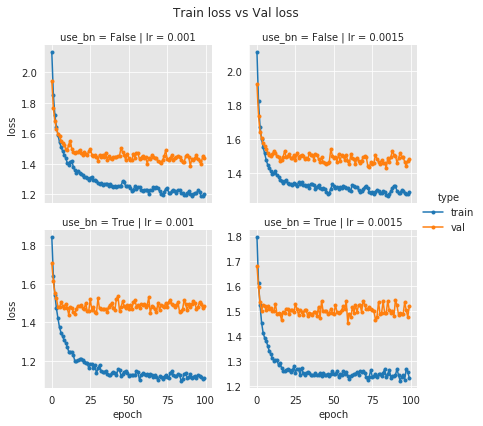

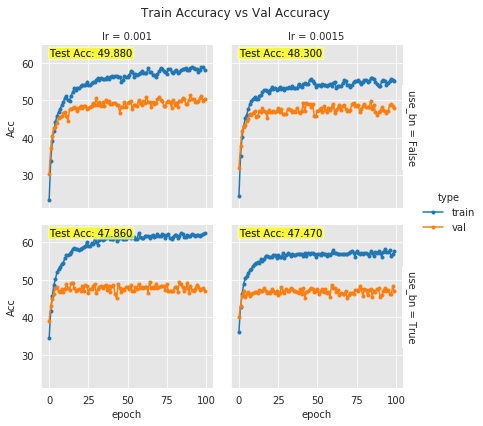

In [34]:
var1 = 'lr'
var2 = 'use_bn'
df = load_exp_result('exp3')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

In [ ]:
##Experiment4. Past testcase

In [35]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp4_a_pastTestCase"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 500
args.n_layer = 2
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.1
args.use_bn = False
args.l2 = 0.01
args.use_xavier = False

# ====== Optimizer & Training ====== #
args.optim = 'SGD' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.001
args.epoch = 100

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'use_bn'
list_var1 = [0.001, 0.002]
list_var2 = [False]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.1, epoch=100, exp_name='exp4_a_pastTestCase', hid_dim=500, in_dim=3072, l2=0.01, lr=0.001, n_layer=2, optim='SGD', out_dim=10, test_batch_size=1024, train_batch_size=512, use_bn=False, use_xavier=False)
Epoch 0, Acc(train/val): 20.25/23.68, Loss(train/val) 2.24/2.13. Took 4.33 sec
Epoch 1, Acc(train/val): 27.82/31.18, Loss(train/val) 2.06/1.97. Took 4.21 sec
Epoch 2, Acc(train/val): 31.74/34.58, Loss(train/val) 1.92/1.87. Took 4.27 sec
Epoch 3, Acc(train/val): 35.21/36.50, Loss(train/val) 1.84/1.80. Took 4.19 sec
Epoch 4, Acc(train/val): 36.77/38.10, Loss(train/val) 1.78/1.76. Took 4.17 sec
Epoch 5, Acc(train/val): 38.66/39.60, Loss(train/val) 1.73/1.72. Took 4.27 sec
Epoch 6, Acc(train/val): 40.08/41.14, Loss(train/val) 1.69/1.69. Took 4.09 sec
Epoch 7, Acc(train/val): 41.13/41.79, Loss(train/val) 1.66/1.66. Took 4.31 sec
Epoch 8, Acc(train/val): 42.35/42.11, Loss(train/val) 1.64/1.64. Took 4.14 sec
Epoch 9, Acc(train/val): 43.13/42.91, Loss(train/val) 

Namespace(act='relu', dropout=0.1, epoch=100, exp_name='exp4_a_pastTestCase', hid_dim=500, in_dim=3072, l2=0.01, lr=0.002, n_layer=2, optim='SGD', out_dim=10, test_batch_size=1024, train_batch_size=512, use_bn=False, use_xavier=False)
Epoch 0, Acc(train/val): 21.75/25.72, Loss(train/val) 2.20/2.07. Took 3.99 sec
Epoch 1, Acc(train/val): 30.24/33.85, Loss(train/val) 1.97/1.86. Took 3.99 sec
Epoch 2, Acc(train/val): 35.53/37.26, Loss(train/val) 1.81/1.77. Took 3.97 sec
Epoch 3, Acc(train/val): 38.46/39.28, Loss(train/val) 1.73/1.71. Took 3.97 sec
Epoch 4, Acc(train/val): 40.43/41.35, Loss(train/val) 1.68/1.66. Took 4.08 sec
Epoch 5, Acc(train/val): 42.30/42.02, Loss(train/val) 1.63/1.64. Took 4.15 sec
Epoch 6, Acc(train/val): 43.64/43.33, Loss(train/val) 1.60/1.61. Took 4.15 sec
Epoch 7, Acc(train/val): 44.94/43.55, Loss(train/val) 1.56/1.59. Took 4.07 sec
Epoch 8, Acc(train/val): 45.85/43.96, Loss(train/val) 1.54/1.57. Took 3.97 sec
Epoch 9, Acc(train/val): 46.70/45.19, Loss(train/val) 

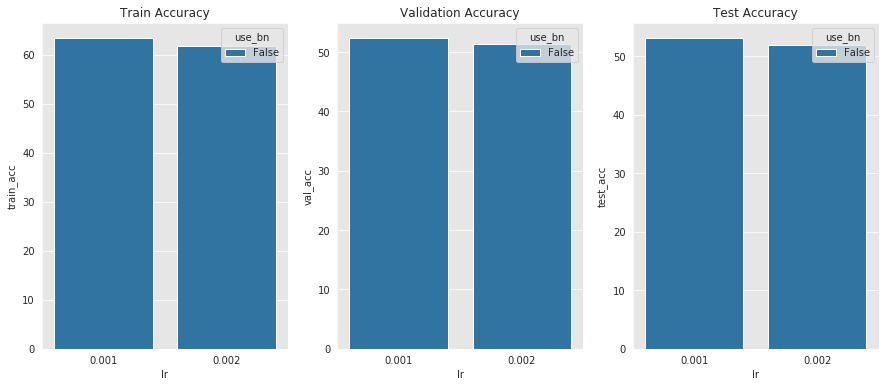

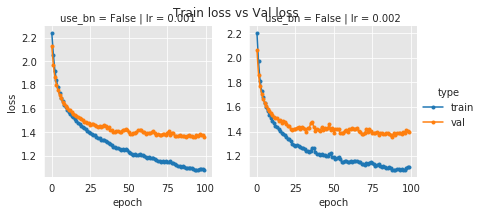

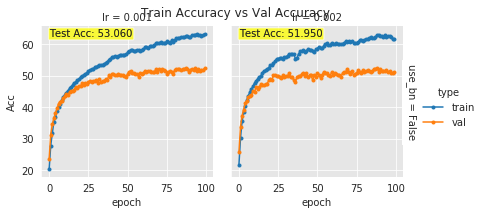

In [37]:
var1 = 'lr'
var2 = 'use_bn'
df = load_exp_result('exp4_a')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) 